In [1]:
import random
from pathlib import Path
import os

import torch
import torchvision.models as models
from torchinfo import summary

from load_data_functions import create_cv_datasets, create_dataloaders
from engine import load_enet_baseline, get_loss_optimizer, create_writer, train, pretty_json, plot_loss_curves, pred_and_plot_n_images

In [2]:
# get current hyperparameter setup
batch_size = 64
loss_fn_str = "MSE"
learning_rate = 0.001
optimizer_str = "Adam"
num_epochs = 30
train_percentage = 1.0

In [3]:
# other variables relevant for training
project_path = os.getcwd()
split_path = Path("data/train_test_split")
fold_list = [split_path / f"fold_{i}" for i in range(1, 6)]
used_fold = "fold_1"
img_size = 256
model_name = "enet_baseline"

In [4]:
# setup device agnostic code
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [5]:
# load an EfficientNet-B0 model with a custom classifier head
model = load_enet_baseline(device)
summary(model=model,
        input_size=(32, 3, img_size, img_size),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

[INFO] Created a new baseline EfficientNet-B0 model.


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 256, 256]    [32, 1]              --                   True
├─Sequential (features)                                      [32, 3, 256, 256]    [32, 1280, 8, 8]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 256, 256]    [32, 32, 128, 128]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 256, 256]    [32, 32, 128, 128]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 128, 128]   [32, 32, 128, 128]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 128, 128]   [32, 32, 128, 128]   --                   --
│    └─Sequential (1)                                        [32, 32, 128, 128]   [32, 16, 128

In [6]:
# get loss function and optimizer
loss_fn, optimizer = get_loss_optimizer(loss_fn_str, optimizer_str, model, learning_rate)

In [7]:
# get the standard transforms for the EfficientNet B0 (see https://www.learnpytorch.io/06_pytorch_transfer_learning/)
weights = models.EfficientNet_B0_Weights.DEFAULT
auto_transforms = weights.transforms()

In [8]:
# load training and validation data (only one fold to see how training goes)
datasets = create_cv_datasets(fold_list, auto_transforms, select_one=True, train_percentage=train_percentage)
train_data = datasets[used_fold]["train"]
validation_data = datasets[used_fold]["validation"]
print(f"Size of the training set: {len(train_data)}")
print(f"Size of the validation set: {len(validation_data)}")
train_loader, val_loader = create_dataloaders(train_data, validation_data, device, batch_size)

Size of the training set: 19803
Size of the validation set: 4915


In [9]:
# create a writer to track training results
writer = create_writer(f"model_selection", model_name, project_path=project_path)

[INFO] Created SummaryWriter, saving to: C:\local\AIProject\runs\model_selection\enet_baseline\2024-05-26_10-37-03...


In [10]:
# track hyperparameters and other important information
info = {
        "model_name": model_name,
        "batch_size": batch_size,
        "loss_fn_str": loss_fn_str,
        "learning_rate": learning_rate,
        "augmentation": False,
        "split_path": str(split_path),
        "fold_list": [str(fold) for fold in fold_list],
        "validation_fold": used_fold,
        "img_size": img_size,
        "num_epochs": num_epochs,
        "optimizer_str": optimizer_str,
        "percentage": train_percentage
    }

writer.add_text("Miscellaneous", pretty_json(info))

In [11]:
# train the model and track performance
model.to(device)
performance = train(num_epochs=num_epochs,
                    model=model,
                    train_loader=train_loader,
                    val_loader=val_loader,
                    loss_fn=loss_fn,
                    optimizer=optimizer,
                    device=device,
                    writer=writer,
                    early_stopping=True)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.0889 | train_ccc: 0.1945 | train_pcc: 0.2251 | val_loss: 0.0984 | val_ccc: 0.1181 | val_pcc: 0.1712
Epoch: 2 | train_loss: 0.0878 | train_ccc: 0.1365 | train_pcc: 0.1572 | val_loss: 0.0814 | val_ccc: -0.0000 | val_pcc: 0.0122
Epoch: 3 | train_loss: 0.0995 | train_ccc: 0.0484 | train_pcc: 0.0586 | val_loss: 0.1381 | val_ccc: 0.0013 | val_pcc: 0.1730
Epoch: 4 | train_loss: 0.0957 | train_ccc: 0.0001 | train_pcc: 0.0001 | val_loss: 0.0820 | val_ccc: 0.0007 | val_pcc: 0.0319
Epoch: 5 | train_loss: 0.0936 | train_ccc: -0.0019 | train_pcc: -0.0015 | val_loss: 0.0810 | val_ccc: 0.0221 | val_pcc: 0.0421
Epoch: 6 | train_loss: 0.0880 | train_ccc: 0.0050 | train_pcc: 0.0102 | val_loss: 0.0816 | val_ccc: 0.0108 | val_pcc: 0.1475
Epoch: 7 | train_loss: 0.0782 | train_ccc: 0.0409 | train_pcc: 0.1094 | val_loss: 0.0809 | val_ccc: 0.0113 | val_pcc: -0.0471
Epoch: 8 | train_loss: 0.0749 | train_ccc: 0.0887 | train_pcc: 0.2051 | val_loss: 0.0753 | val_ccc: 0.0374 | val_pcc: 0.0

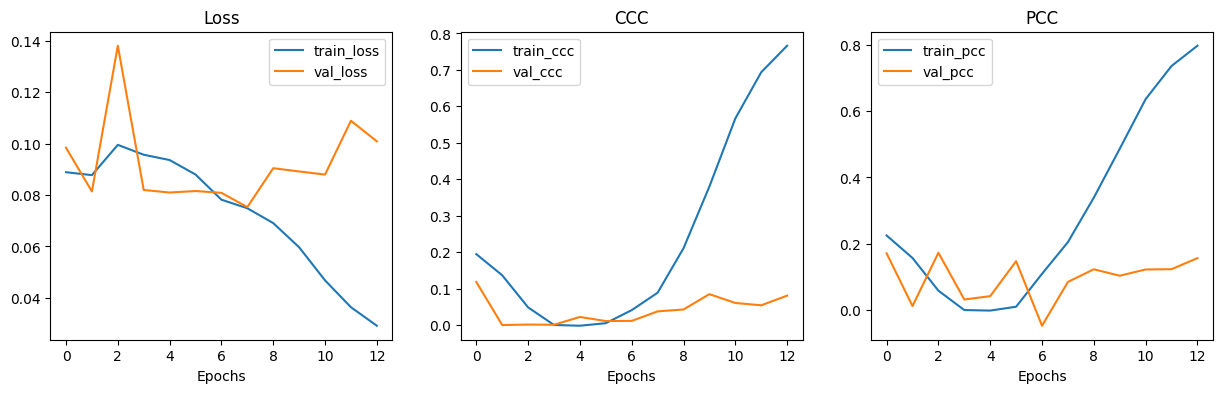

In [12]:
# plot loss curves
plot_loss_curves(performance)

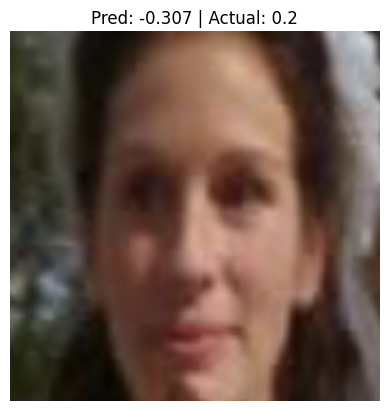

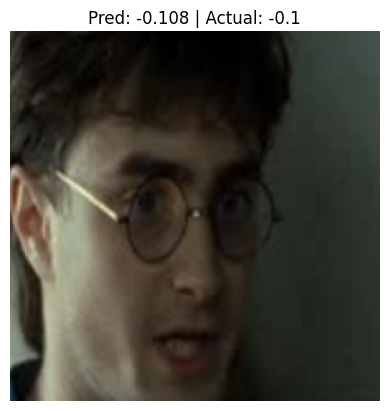

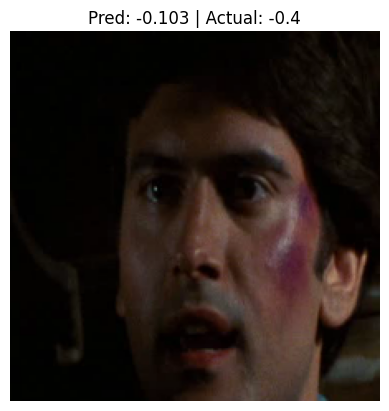

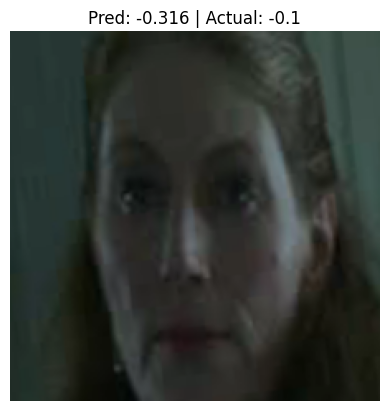

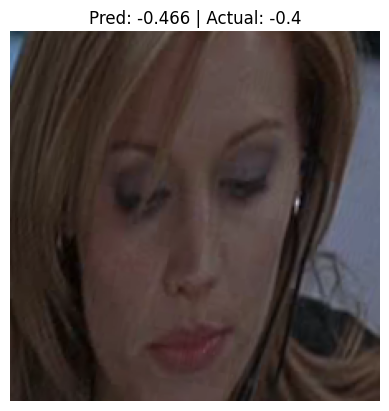

In [13]:
# make predictions
pred_and_plot_n_images(model=model, 
                       val_path = str(fold_list[0]), 
                       num_images_to_plot=5, 
                       image_size=(img_size, img_size), 
                       transform=auto_transforms,
                       device=device)